In [1]:
import sys,os, glob, time, astropy, warnings, pickle
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pandas as pd
from scipy.stats import *
from astropy.stats import histogram
from astropy.io import fits
import sklearn.mixture.gaussian_mixture as GMM
from builtins import zip
### LSST dependencies 
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils.mafUtils import radec2pix
from lsst.sims.maf.utils import m52snr, astrom_precision
sys.path.append('/home/idies/LSST_OpSim/Scripts_NBs/')
from opsimUtils import *

In [2]:
def sigma_slope_arr(x, sigmay):
    w = 1./np.array(sigmay)**2
    denom = np.sum(x)*np.sum(w*x**2,axis=1)-np.sum(w*x,axis=1)**2
    denom[np.where(denom <= 0)]=np.nan
    denom[np.where(denom > 0)] = np.sqrt(np.sum(w)*denom[np.where(denom > 0)]**-1 )
    return denom

In [3]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook. 
         raise Exception('Please provide your username!  See the top of the notebook.') 

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/' 
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/CadenceNote'.format(your_username) 

if not os.path.exists(os.path.abspath(outDir)): 
     os.mkdir(os.path.abspath(outDir)) 
dbRuns = show_opsims(dbDir) 
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [4]:
sqlconstraint ='proposalID =1 and note not like  "DD%" '
slicer = slicers.HealpixSlicer(nside=16) 

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [5]:
class CadenceNotePM(BaseMetric): 
    
        def readfile(self, filename='', colsname=['']): 
            if 'csv' in filename: 
                #print('reading {}'.format(filename)) 
                data = pd.read_csv(filename, header=0, names = colsname ) 
            elif 'fits' in filename: 
                 #print('reading {}'.format(filename)) 
                hdul = fits.open(filename) 
                data = hdul[1].data 
            elif ['txt', 'dat'] in filename: 
                #print('reading {}'.format(filename)) 
                data = {k:[] for k in colsname} 
                f = open(filename) 
                righe = f.readlines() 
                for line in righe: 
                    line.split() 
                    for i, k in enumerate(colsname): 
                        data[k].append(float(line[i]))                 
            elif 'json'in filename: 
                print('not implemented to read .json extention') 
            return data 
        
        def __init__(self, filename = 'data.csv', snr_lim=5,mode=None, MagIterLim=[0,1,1], surveyduration=10,
                      metricName='CadenceNotePM',m5Col='fiveSigmaDepth',real_data= True, out_type = 'confusion',
                      mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=True,**kwargs): 
            
            self.mjdCol = mjdCol 
            self.m5Col = m5Col 
            self.seeingCol = seeingCol 
            self.filterCol = filterCol 
            self.snr_lim = snr_lim 
            self.filename = filename  
            self.dataout = dataout 
            self.mode = mode 
            self.MagIterLim = MagIterLim 
            self.surveyduration = surveyduration 
            self.out_type = out_type
            self.real_data = real_data
             # to have as output all the simulated observed data set dataout=True, otherwise the relative error for  
             # each helpix is estimated 
            if self.dataout: 
                super(CadenceNotePM, self).__init__(col=[self.mjdCol,self.filterCol, self.m5Col,self.seeingCol, 'night' ],metricDtype='object', units='', metricName=metricName, 
                                                      **kwargs) 
            else: 
                super(CadenceNotePM, self).__init__(col=[self.mjdCol,self.filterCol,  self.m5Col,self.seeingCol, 'night' ], 
                                                            units='', metricDtype='float',metricName=metricName, 
                                                             **kwargs) 
            if self.real_data:    
                colsname=['RA', 'DEC','g','g-r','Hg','PM_OUT','deltaX'] 
                self.data = self.readfile(self.filename, colsname)
                self.data['MAG']=self.data['g']
            else:
                colsname=['MAG','MODE','d','PM','PM_OUT']
                self.data = self.readfile(self.filename, colsname)
            
        def run(self, dataSlice, slicePoint=None): 
            pm = self.data['PM_OUT']
            mag = self.data['MAG']
            obs = np.where(dataSlice[self.mjdCol]<min(dataSlice[self.mjdCol])+365*self.surveyduration)
            
            deltamag= np.arange(self.MagIterLim[0],self.MagIterLim[1],self.MagIterLim[2])
            out = {}
            for dm in deltamag: 
                    
                    if self.mode == 'distance': 
                        pmnew= pm/(10**(dm/5)) 
                    elif self.mode == 'density': 
                        pmnew= pm 
                    else: 
                        print('##### ERROR: the metric is not implemented for this mode.')
                        
                    mjd = dataSlice[self.mjdCol][obs]
                    flt = dataSlice[self.filterCol][obs]
                    if ('g' in flt) and ('r' in flt):
                        
                        # select objects above the limit magnitude threshold 
                        snr = m52snr(mag[:, np.newaxis],dataSlice[self.m5Col][obs])
                        row, col =np.where(snr>self.snr_lim)
                        precis = astrom_precision(dataSlice[self.seeingCol][obs], snr)
                        sigmapm=sigma_slope_arr(dataSlice[self.mjdCol][obs], precis)*365.25*1e3
                           
                        out[dm] = {'sigmapm': sigmapm}  
            if self.dataout: 
                return out  
            else:
                if ('g' in flt) and ('r' in flt):
                    res = np.nanmean(out[dm]['sigmapm'])
                    return res 

In [6]:
metricCI= CadenceNotePM(metricName='CI',filename='data.csv',snr_lim=5,mode='distance', surveyduration = 10, real_data=True,
                    MagIterLim=[0,1,1],m5Col='fiveSigmaDepth',mjdCol='observationStartMJD',filterCol='filter', 
                    seeingCol='seeingFwhmGeom',dataout=False)
metricSkyCI = metricBundles.MetricBundle(metricCI,slicer,sqlconstraint)

In [7]:
bundleDict={'CI': metricSkyCI}

In [8]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/CadenceNote'.format(your_username)

# below I am only going to run metrics on the first five opsims
for i, run in  enumerate(dbRuns):
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    metricSkyCI.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print( '--- {:.2f} minutes ---\n'.format((time.time() - start_time)/60))
    print('####################\n')

##############

N_1, dcr_nham1_ugri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID =1 and note not like  "DD%"  for columns ['fiveSigmaDepth', 'fieldDec', 'filter', 'night', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 1852536 visits
Running:  ['CI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 6.44 minutes ---

####################

##############

N_2, rolling_mod6_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint proposalID =1 and note not like  "DD%"  for columns ['fiveSigmaDepth', 'fieldDec', 'filter', 'night', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 1867023 visits
Running:  ['CI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 6.32 minutes ---

####################

##############

N_3, wfd_depth_scale0.95_noddf_v1.5_10yrs is running

##############

Q

In [9]:
resultDbPath= '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/CadenceNote'.format(your_username)

# get a dictionary of resultDb from given directory 
resultDbs2 = getResultsDbs(outDir) 

# the following line will be useful if you did not run MAF on all 75 opsims 
runNames = list(resultDbs2.keys()) 
bundleDicts = {} 
for runName in dbRuns: 
     bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, resultDbPath)
for k in dbRuns:
    print(bundleDicts[k].keys())

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

In [10]:
mafs = {k:None for k in dbRuns}
coo = {k:None for k in dbRuns}
for db in dbRuns:
    
    c= np.column_stack((bundleDicts[db][(1,'CI')].slicer.slicePoints['ra'][np.where(bundleDicts[db][(1,'CI')].metricValues.mask==False)]
                                  ,bundleDicts[db][(1,'CI')].slicer.slicePoints['dec'][np.where(bundleDicts[db][(1,'CI')].metricValues.mask==False)]))
    
    coo[db]=c
    arr = bundleDicts[db][(1,'CI')].metricValues.data
    arr_ = arr[arr!= None]
    if isinstance(arr_[0], dict):
        mafs[db]=pd.DataFrame.from_records(arr_)
    else:
        mafs[db]=bundleDicts[db][(1,'CI')].metricValues[np.where(bundleDicts[db][(1,'CI')].metricValues.mask==False)]


In [36]:
mafs[dbRuns[1]]

masked_array(data=[nan, nan, nan, ..., nan, nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-1.6375e+30)

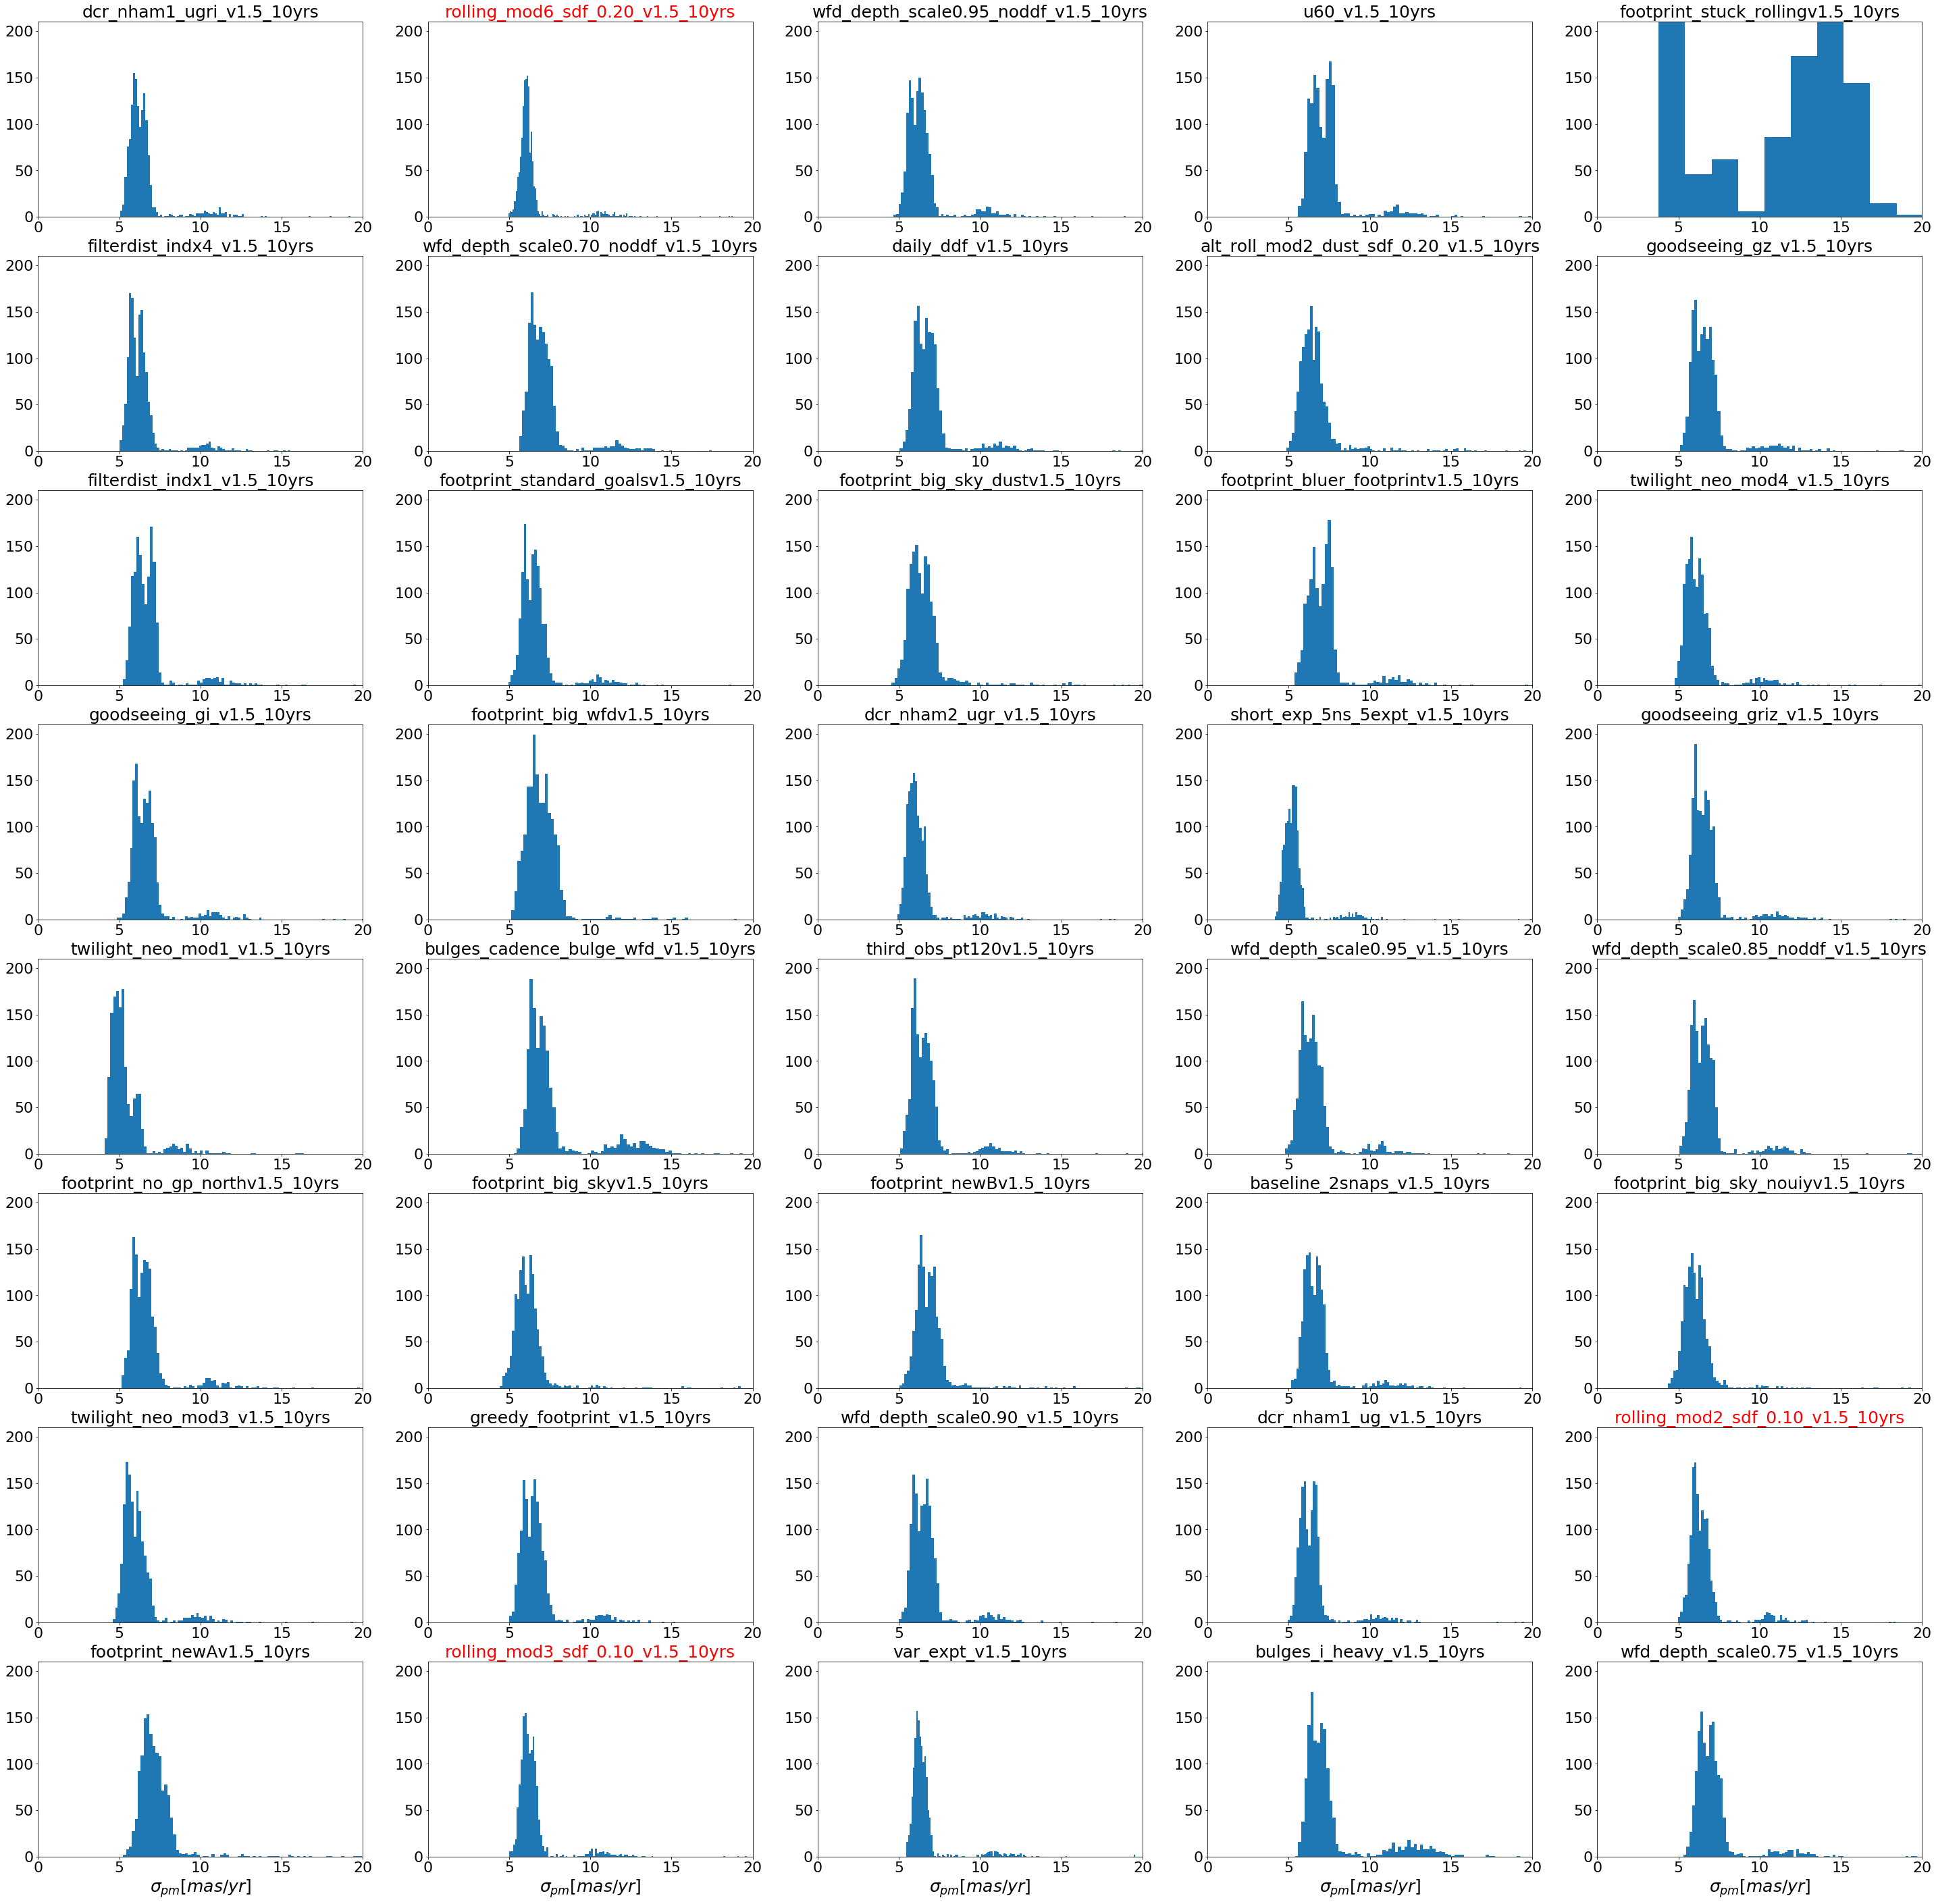

In [31]:
fig, axes = plt.subplots(8,5,figsize=(50,50))
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
for i, (ax,db) in enumerate(zip(axes.flatten()[0:40], dbRuns[0:40])):
    ax.hist(mafs[db][np.isfinite(mafs[db])], 'auto')
    ax.set_xlim([0,20])
    ax.set_ylim([0,210])
    if i>34:
        ax.set_xlabel(r'$\sigma_{pm}[mas/yr]$', fontsize=25)
    if 'rolling' in db.split('_'):
        ax.set_title(db, color='r', fontsize=25)
    else:
        ax.set_title(db, fontsize=25)
plt.show()

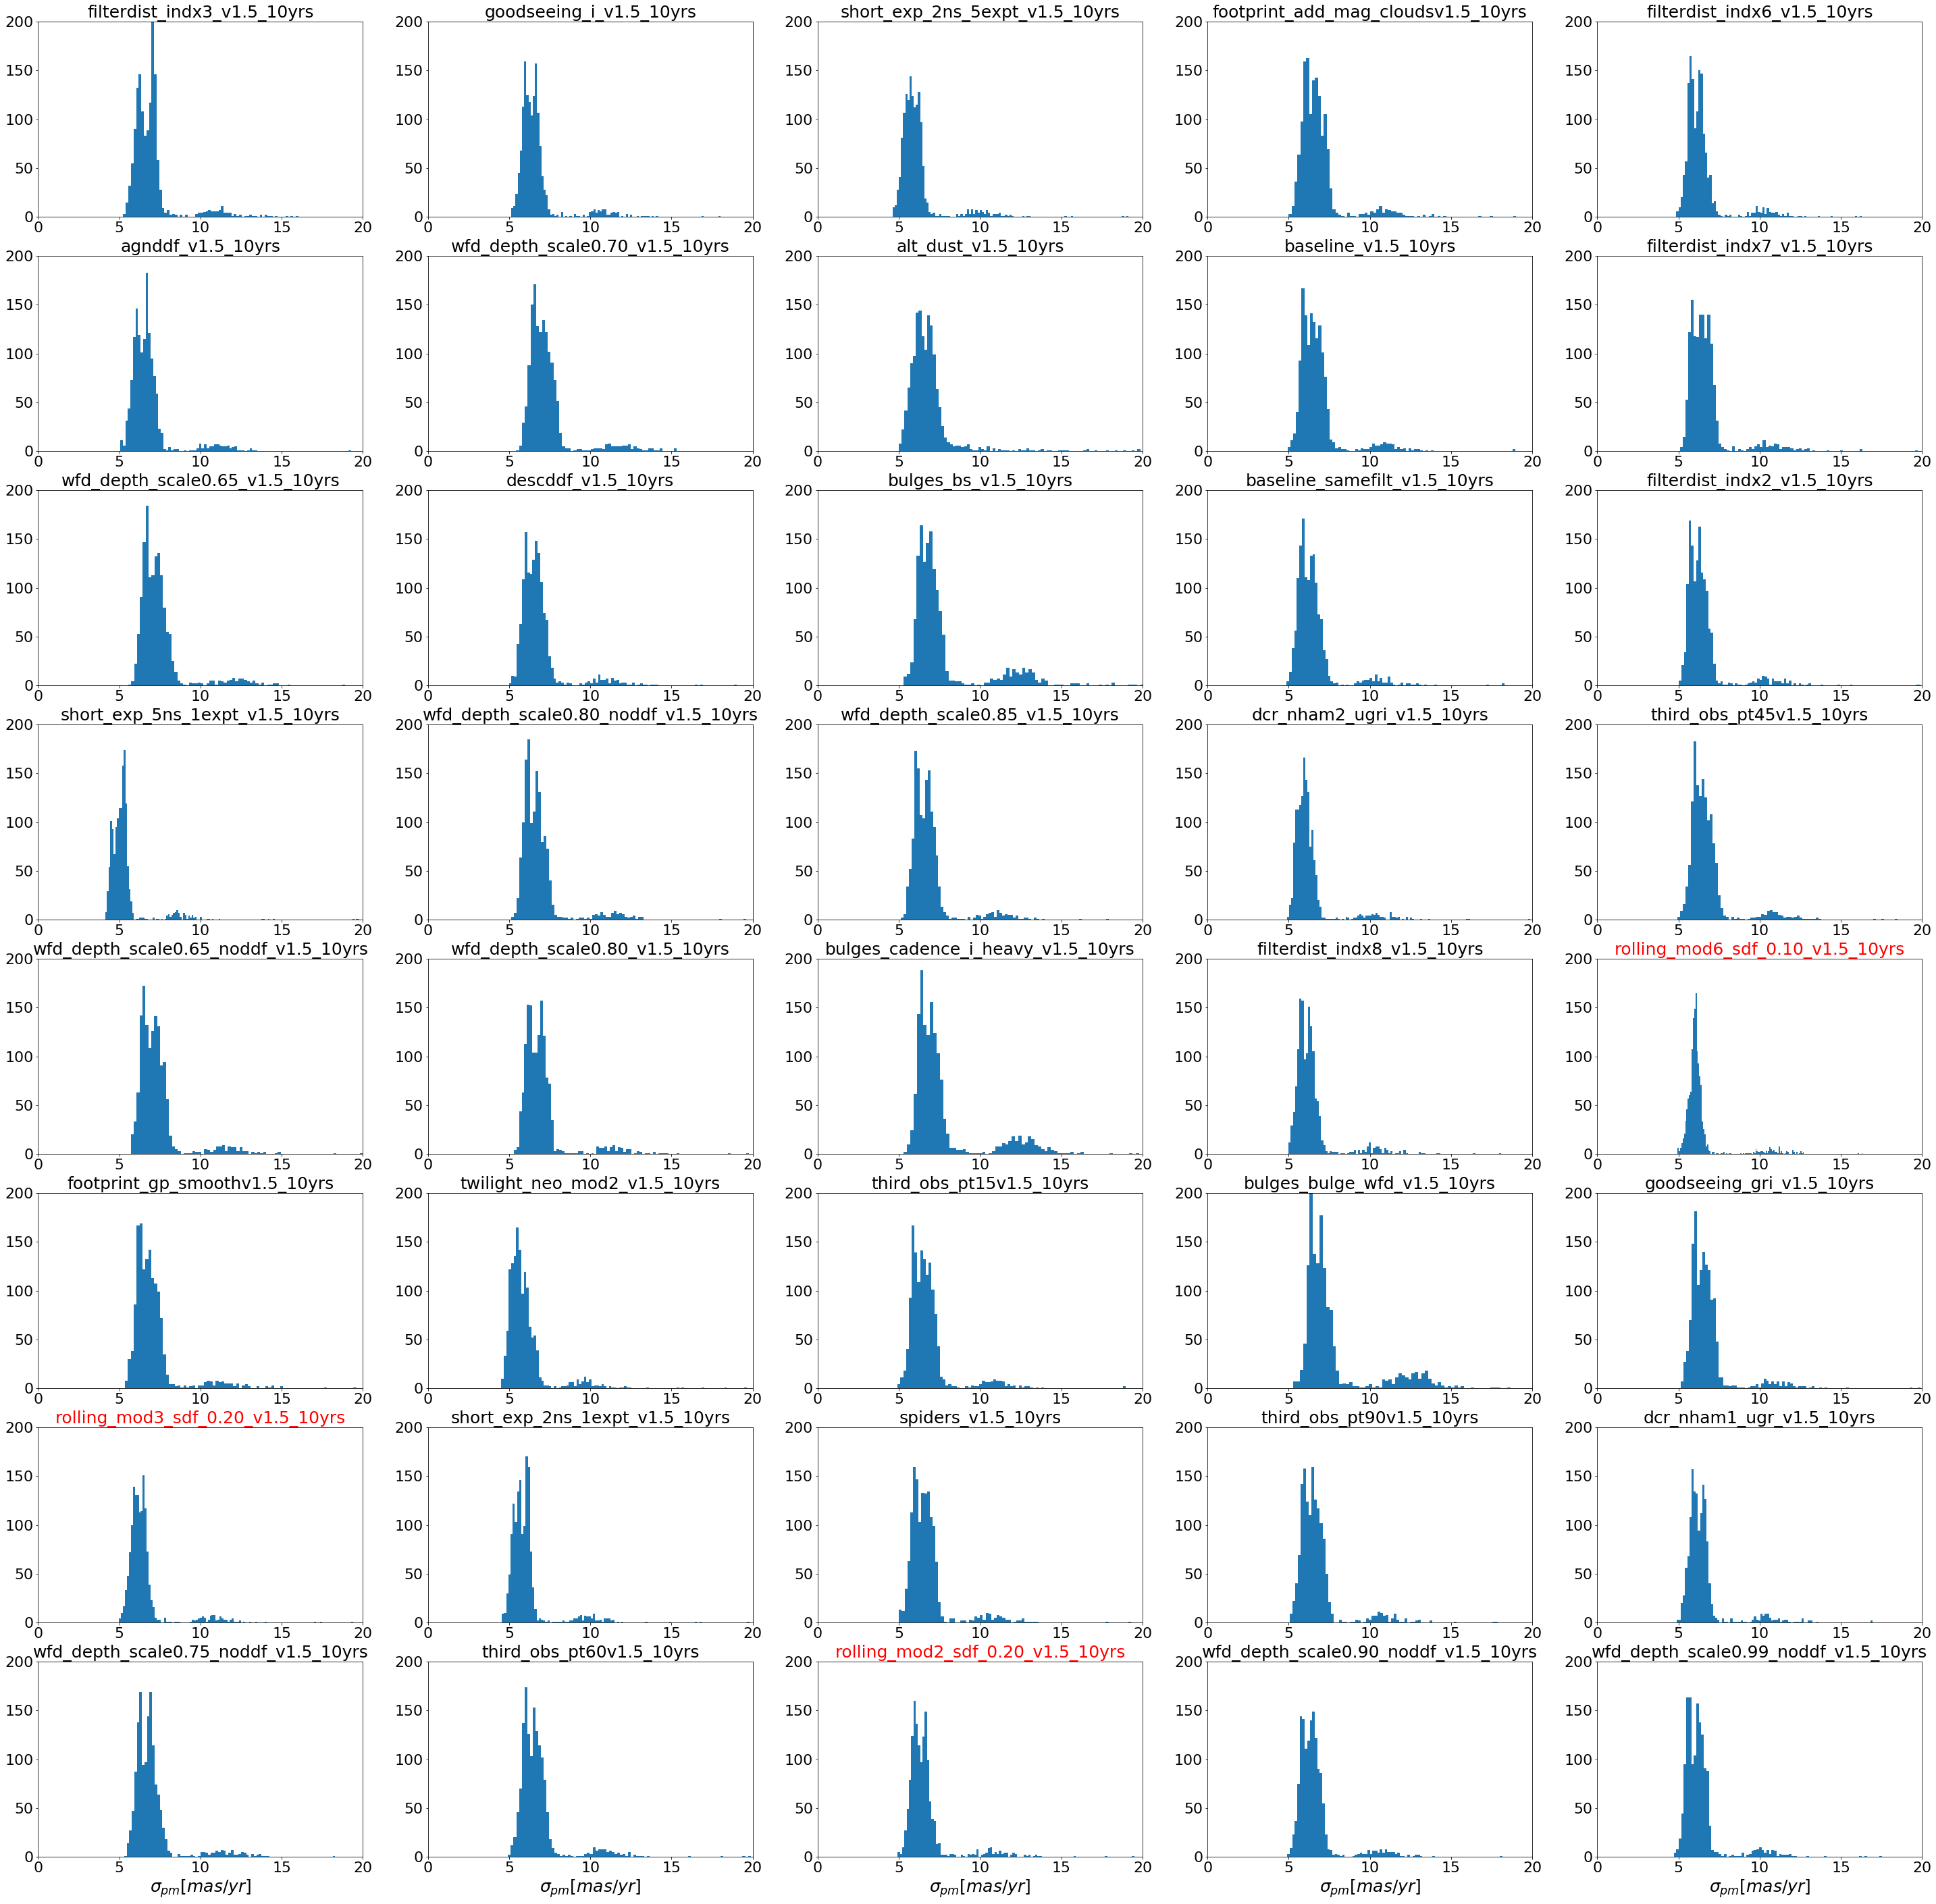

In [32]:
fig, axes = plt.subplots(8,5,figsize=(50,50))
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
for i, (ax,db) in enumerate(zip(axes.flatten(), dbRuns[41:81])):
    ax.hist(mafs[db][np.isfinite(mafs[db])], 'auto')
    ax.set_xlim([0,20])
    ax.set_ylim([0,200])
    if i >34:
        ax.set_xlabel(r'$\sigma_{pm}[mas/yr]$', fontsize=25)
    if 'rolling' in db.split('_'):
        ax.set_title(db, color='r', fontsize=25)
    else:
        ax.set_title(db, fontsize=25)
plt.show()

In [76]:
from pylab import cm
def plt_mlw(ax,ra,dec,org=0,projection='mollweide',c= 'null', vmin=0,vmax=1, dicts={}):
    args={'colormap': None,'marker':'o','linewidths':0,'title':'mlw_plot','xlabel':'','ylabel':'', 'fontsize':12,'cbartitle': 'score','psize':10}
    if dicts:
        args.update(dicts)
    if args['colormap']:
        cmap = cm.get_cmap(args['colormap'])
    else:
        cmap=None
        
    if c =='null':
        c= np.ones(len(ra))
    else:
        c=c
     
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    ax.set_title(args['title'])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis    
    ax.title.set_fontsize(5)
    ax.set_xlabel(args['xlabel'])
    ax.xaxis.label.set_fontsize(5)
    ax.set_ylabel(args['ylabel'])
    ax.yaxis.label.set_fontsize(5)
    ax.grid(True)
    im=ax.scatter(np.radians(x),np.radians(dec),c=c, s=args['psize'],cmap=cmap, marker = args['marker'], vmin = vmin, vmax = vmax, linewidths = args['linewidths'], zorder = 0)
    ax.tick_params('both', labelsize=5)
    #if cmap:
    #    cb=plt.colorbar(im,aspect=50,orientation='horizontal')
    #    cb.set_label(args['cbartitle'], size=5)
    #    for t in cb.ax.get_xticklabels():
    #         t.set_fontsize(12)

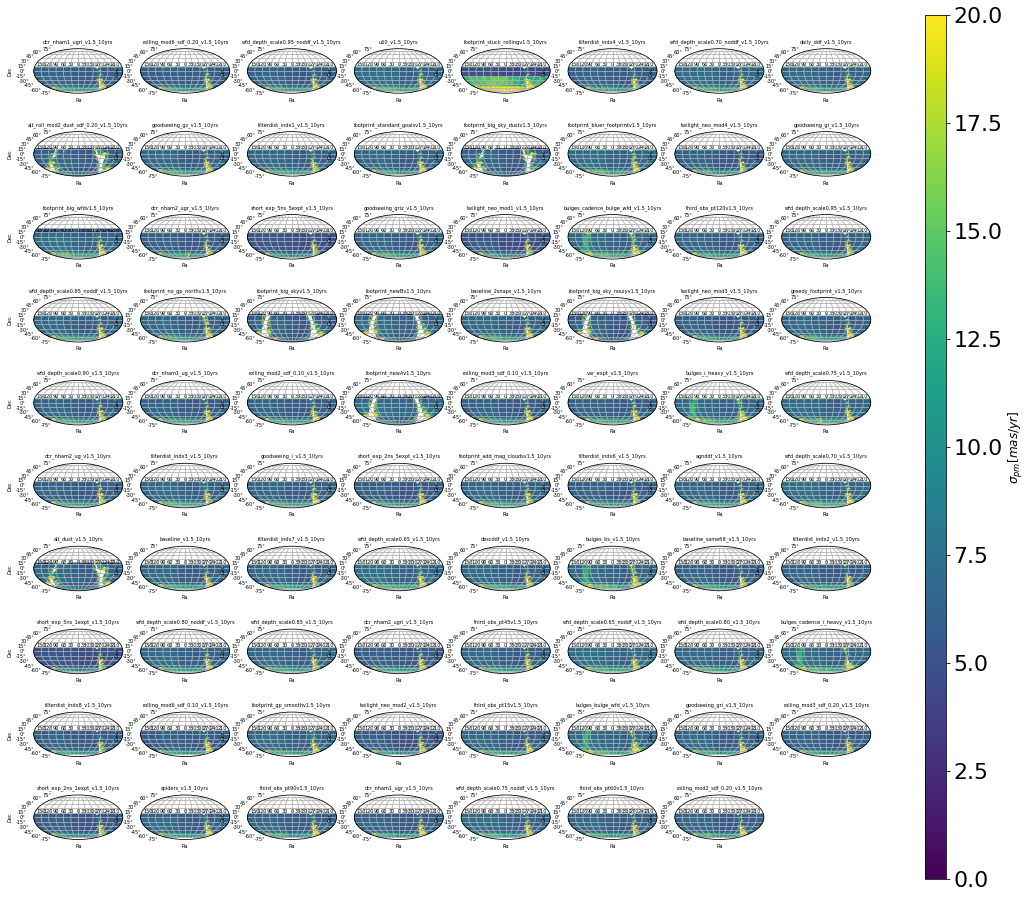

In [87]:
import matplotlib as mpl
from itertools import product 
import matplotlib.gridspec as gridspec
mpl.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(15,15))
for i,  key in enumerate(dbRuns[0:79]):#['baseline_v1.5_10yrs','footprint_stuck_rollingv1.5_10yrs','wfd_depth_scale0.99_v1.5_10yrs','short_exp_5ns_5expt_v1.5_10yrs', 'rolling_mod3_sdf_0.10_v1.5_10yrs','goodseeing_griz_v1.5_10yrs']):
    ax= fig.add_subplot(10,8,i+1, projection='mollweide')
    ra, dec = coo[key][:,0][np.isfinite(mafs[key])], coo[key][:,1][np.isfinite(mafs[key])]
    c=mafs[key][np.isfinite(mafs[key])].data
    #if i ==6:
    #    im=plt_mlw(ra=np.degrees(ra),dec=np.degrees(dec),ax=ax, c= c,vmin=0,vmax=20, dicts={'marker':'h','cbartitle':r'$\sigma_{pm}[mas/yr]$','psize':25,'title':key, 'colormap':'viridis'
    #                                                                                                        ,'ylabel':'Dec','xlabel':'Ra'})
    #else:
    plt_mlw(ra=np.degrees(ra),dec=np.degrees(dec),ax=ax, c=c,vmin=0,vmax=20, dicts={'marker':'h','cbartitle':r'$\sigma_{pm}[mas/yr]$','psize':25,'title':key, 'colormap':'viridis'
                                                                                              ,'ylabel':'Dec','xlabel':'Ra'})
im=plt.scatter(np.ones(np.size(c)),np.ones(np.size(c)),c=c, s=0,cmap='viridis', marker = 'o', vmin = 0, vmax = 20, linewidths = 0, zorder = 0)    
cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
#cb=plt.colorbar(im,aspect=50,orientation='horizontal')
cbar.set_label(r'$\sigma_{pm}[mas/yr]$', size=12)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(8)
#plt.savefig('SkyMap_astrometry.pdf')